In [1172]:
import gensim
from gensim import corpora
import multiprocessing
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import pkg_resources
import pandas as pd
import numpy as np

In [1173]:
import pandas as pd
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
import random
import warnings
warnings.filterwarnings("ignore")

In [1174]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [1908]:
df = pd.read_csv('tweets_processed.csv', usecols=['clean_keyword', 'clean_location'])
df2 = pd.read_csv('tweets_update.csv', usecols=['denoised_text', 'lem_tokes', 'lem_adv'])
df['lem_v'] = df2['lem_tokes']
df['lem_av'] = df2['lem_adv']
df['tweets'] = df2['denoised_text']

In [1909]:
df

,clean_keyword,clean_location,lem_v,lem_av,tweets
0,NaN,NaN,our deeds be the reason of this earthquake may...,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake m...
1,NaN,NaN,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,NaN,NaN,all residents ask to shelter in place be be no...,all residents asked to shelter in place are be...,all residents asked to shelter in place are b...
3,NaN,NaN,people receive wildfires evacuation order in c...,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders in...
4,NaN,NaN,just get send this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as ...
...,...,...,...,...,...
10871,NaN,NaN,earthquake safety los angeles safety fasteners...,earthquake safety los angeles safety fasteners...,earthquake safety los angeles safety fasteners...
10872,NaN,NaN,storm in rhode island worse than last hurrican...,storm in rhode island worse than last hurrican...,storm in rhode island worse than last hurrica...
10873,NaN,NaN,green line derailment in chicago,green line derailment in chicago,green line derailment in chicago
10874,NaN,NaN,meg issue hazardous weather outlook hwo,meg issues hazardous weather outlook hwo,meg issues hazardous weather outlook hwo


In [1910]:
target_df = pd.read_csv('train.csv', usecols=['target'])
target = list(target_df.target)

In [1911]:
target_df.target.isna().sum()

0

In [1912]:
train_len = len(target)

In [1913]:
train_df, test_df = df.iloc[:train_len, :], df.iloc[train_len:, :] 
train_df['target'] = target
train_df.drop_duplicates(subset=['tweets'], keep='last', inplace=True)

In [1914]:
len(train_df)

6830

In [1915]:
len(test_df)

3263

In [1916]:
tweets = list(train_df.lem_av)
for x in test_df.lem_av:
    tweets.append(x) 
len(tweets)

10093

In [2209]:
def kw_loc_column_fix(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'\bnan\b', r'')
    df['clean_keyword'] = df.clean_keyword.str.replace(r' ', r'_')
    df['clean_keyword'] = df.clean_keyword.str.strip()
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.strip()
    df['clean_location'] = df.clean_location.str.replace(r'\bnan\b', r'')
    df['clean_location'] = df.clean_location.str.replace(r' ', r'_')
    return df

In [2210]:
df = kw_loc_column_fix(df)

In [2211]:
train_df = kw_loc_column_fix(train_df)
test_df = kw_loc_column_fix(test_df)

In [2212]:
keyword = pd.get_dummies(train_df.clean_keyword, prefix='keyword')
location = pd.get_dummies(train_df.clean_location, prefix='location')
train_df_secondary = pd.concat([keyword, location], axis=1)

keyword_test = pd.get_dummies(test_df.clean_keyword, prefix='keyword')
location_test = pd.get_dummies(test_df.clean_location, prefix='location')
test_df_secondary = pd.concat([keyword_test, location_test], axis=1)

In [2213]:
train_df['all_text'] = train_df[['lem_av', 'clean_location', 'clean_keyword']].agg(' '.join, axis=1)
test_df['all_text'] = test_df[['lem_av', 'clean_location', 'clean_keyword']].agg(' '.join, axis=1)

## wordcloud

In [2167]:
from wordcloud import WordCloud
def plot_wordcloud (df): 
    pos_ = df[df['target']==1]['lem_av']
    neg_ = df[df['target']==0]['lem_av']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
    wordcloud1 = WordCloud( background_color='black',
                          width=600,
                          height=400).generate(" ".join(pos_)) 

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Disaster Tweets',fontsize=40);
    # Non disaster
    wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(neg_)) 

    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Not Disaster Tweets',fontsize=40);

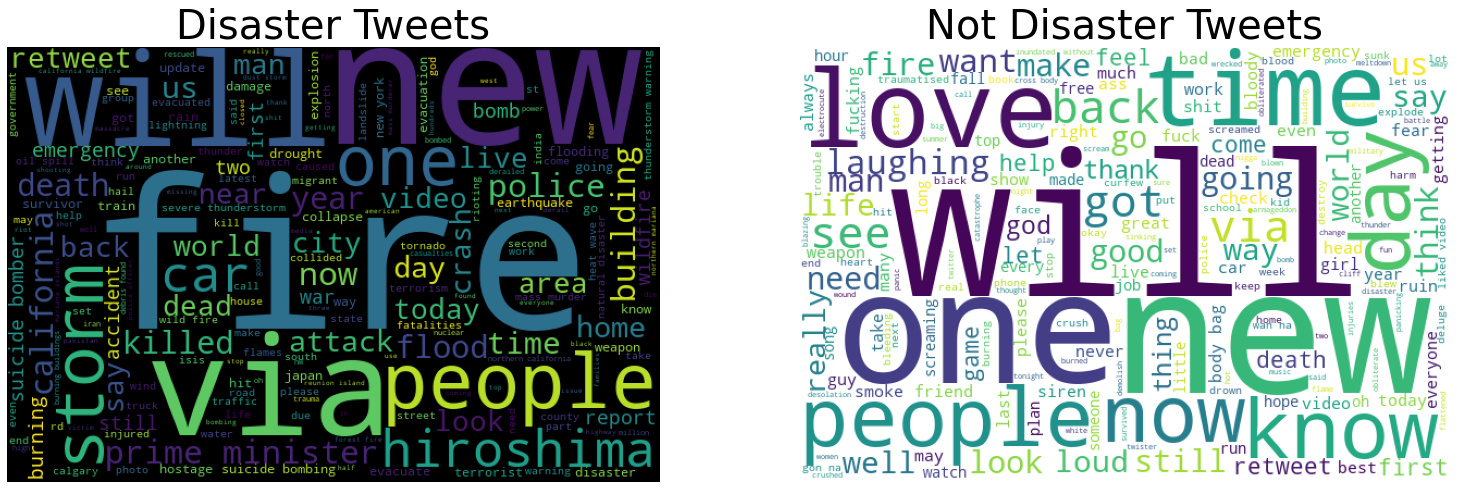

In [2168]:
plot_wordcloud(train_df)

## extract bigrams

In [1950]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from nltk.corpus import stopwords

In [2224]:
tweets = list(train_df.all_text)
for x in test_df.all_text:
    tweets.append(x) 
len(tweets)

def get_documents(text):
    docs = [row.split() for row in text]
    return docs

doc = get_documents(tweets)

def sentence_to_bi_grams(sentence):
    return ' '.join(phrases[sentence])

phrases = Phrases(doc, min_count=5, threshold=.5, connector_words=ENGLISH_CONNECTOR_WORDS)

frozen_phrases = phrases.freeze()

bigrams = []
for row in doc: 
    parsed_sentence = sentence_to_bi_grams(row)
    bigrams.append(parsed_sentence)
    
bigrams

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest_fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just_got sent this photo from ruby alaska as smoke from wildfires pours into school',
 'rocky_fire update california highway closed in both directions due to lake county fire afire wildfires',
 'flood disaster heavy_rain causes flash flooding of streets in manitou colorado springs areas',
 'am on top of the hill and can_see fire in the woods',
 'there_is an emergency evacuation happening now in the building across the street',
 'am afraid that the tornado is_coming to our area',
 'three_people died from the heat_wave so_far',
 'haha south tampa is_getting flooded hah wait second live in south tampa what am_gon na do what am_gon na do fuck flooding',
 'raining flooding florida ta

In [2225]:
new_df = pd.DataFrame()
new_df['tweets'] = tweets
new_df['bigrams'] = bigrams

## prep text for vectorization

In [2226]:
import re

import nltk
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopword_list and len(word) > 1:
                tokens.append(word.lower())
    return tokens

train_tweets = train_df.stems.astype(str).apply(tokenize_text)
test_tweets = test_df.stems.apply(tokenize_text)

In [2227]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
    return tokens

In [2228]:
texts = new_df.tweets.apply(tokenize_text)
bigram_tokes = new_df.bigrams.apply(tokenize_text)

In [2229]:
train_df['texts'] = list(texts[0:6830])
test_df['texts'] = list(texts[6830:])
train_df['bg_texts'] = list(bigram_tokes[0:6830])
test_df['bg_texts'] = list(bigram_tokes[6830:])

In [2230]:
len(train_df)

6830

In [2231]:
test_df['length'] = test_df.texts.str.len()
test_df.loc[test_df['length'] == test_df['length'].min()]

,clean_keyword,clean_location,lem_v,lem_av,tweets,all_text,texts,bg_texts,length
7627,,,awesome,awesome,awesome,awesome,[awesome],[awesome],1
7667,,,aftershock,aftershock,aftershock,aftershock,[aftershock],[aftershock],1
8855,,,displace,displaced,displaced,displaced,[displaced],[displaced],1
9167,,,fatality,fatality,fatality,fatality,[fatality],[fatality],1
9171,,,fatality,fatality,fatality,fatality,[fatality],[fatality],1
9174,,,fatality,fatality,fatality,fatality,[fatality],[fatality],1
9992,,,rainstorm,rainstorm,rainstorm,rainstorm,[rainstorm],[rainstorm],1
10180,,,scream,screams,screams,screams,[screams],[screams],1
10184,,,scream,screams,screams,screams,[screams],[screams],1


In [2232]:
train_df['length'] = train_df.texts.str.len()

train_df.loc[train_df['length'] == train_df['length'].min()]

,clean_keyword,clean_location,lem_v,lem_av,tweets,target,all_text,texts,bg_texts,length,tokens
28,,,cool,cool,cool,0,cool,[cool],[cool],1,[cool]


In [2233]:
X_train, X_test, y_train, y_test = train_test_split(train_df.bg_texts, train_df.target, test_size=0.1, random_state=42)

In [2234]:
from collections import Counter
from statistics import mean

word_dict = Counter(X_train.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
print(f'There are {vocab_size} unique words in the training dataset')
print("max len of training tweets",max([len(x) for x in X_train]))
print("max len of test tweets",max([len(x) for x in X_test]))
print("min len of training tweets",min([len(x) for x in X_train]))
print("min len of test tweets",min([len(x) for x in X_test]))
print("mean len of training tweets", mean([len(x) for x in X_train]))
print("mean len of test tweets",mean([len(x) for x in X_test]))

There are 84105 words in the training dataset
There are 16268 unique words in the training dataset
max len of training tweets 29
max len of test tweets 29
min len of training tweets 1
min len of test tweets 2
mean len of training tweets 13.682284040995608
mean len of test tweets 13.509516837481698


In [2235]:
def get_embedding(word, model, vector_size):
    if word in model.wv:
        return model[x]
    else: 
        return np.zeros(vector_size)

def get_average_vector(model, list_of_tweets):    
    vec_dicts = {}
    for tweet in list_of_tweets:
        average_vector = (np.mean(np.array([get_embedding(tweet, model)]), axis=0))
        v_dict = {tweet : (average_vector)}
        vec_dicts.update(v_dict)
        return vec_dicts

In [2236]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np     
import plotly

In [2237]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly



## uninitialized skipgram

In [2238]:
cores = multiprocessing.cpu_count()

In [2432]:
# uninitializeed model
model_ui_sg = Word2Vec(
        vector_size=100,
        sg=1,
        hs=0,
        negative=8,
        ns_exponent=0.5,
        min_count=4,
        window=3,
        workers=cores)
vocab = model_ui_sg.build_vocab(X_train)

model_ui_sg.train(X_train, total_words=num_words, compute_loss=True, epochs=5)

(291383, 420525)

In [2433]:
model_ui_sg.wv.most_similar(positive="california")

[('calgary', 0.9983222484588623),
 ('pakistan', 0.998203694820404),
 ('san', 0.9981641173362732),
 ('americans', 0.9981416463851929),
 ('idaho', 0.9981363415718079),
 ('harry', 0.9981211423873901),
 ('air', 0.9981176853179932),
 ('scene', 0.9981058239936829),
 ('wet', 0.9980953931808472),
 ('radio', 0.9980933666229248)]

In [2434]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_sg)
plot_function(x_vals, y_vals, labels)

## self initialized skipgram

In [2346]:
# uninitializeed model
model_si_sg = Word2Vec(
        sentences=X_train,
        vector_size=100,
        sg=0,
        min_count=4,
        window=3,
        workers=cores)
vocab = model_si_sg.build_vocab(X_train)

model_si_sg.train(X_train, total_examples=model_ui_bow.corpus_count, compute_loss=True, epochs=2)

(116570, 168210)

In [2347]:
model_si_sg.wv.most_similar(positive="earthquake")

[('about', 0.9996611475944519),
 ('song', 0.9996453523635864),
 ('are', 0.9996387958526611),
 ('my', 0.9996339082717896),
 ('your', 0.9996260404586792),
 ('on', 0.9996219277381897),
 ('was', 0.999614417552948),
 ('gold_coast', 0.9996142983436584),
 ('have', 0.999613344669342),
 ('of', 0.9996105432510376)]

In [2348]:
model_si_sg.wv.most_similar(positive="fire")

[('and', 0.9998226761817932),
 ('off', 0.9998016953468323),
 ('are', 0.9997996091842651),
 ('tracks', 0.9997953772544861),
 ('harm', 0.9997906684875488),
 ('out', 0.9997901916503906),
 ('with', 0.9997837543487549),
 ('by', 0.9997835159301758),
 ('was', 0.9997817277908325),
 ('own', 0.9997761249542236)]

In [2414]:
model_ui_sg.get_latest_training_loss()

403389.875

In [2336]:
x_vals, y_vals, labels = reduce_dimensions(model_si_sg)
plot_function(x_vals, y_vals, labels)

# cbow

In [2440]:
# uninitializeed model
model_ui_bow = Word2Vec(
        vector_size=100, 
        min_count=5,
        negative=6,
        sample=1e-3,
        window=4, 
        workers=cores)

vocab = model_ui_bow.build_vocab(X_train)

model_ui_bow.train(X_train, total_examples=model_ui_bow.corpus_count, epochs=10)

(548541, 841050)

In [2441]:
model_ui_bow.wv.most_similar(positive="wildfire")

[('northern_california', 0.9988043904304504),
 ('evacuation', 0.9986364841461182),
 ('buildings_on_fire', 0.9986071586608887),
 ('california', 0.9985640645027161),
 ('highway', 0.9985190629959106),
 ('st', 0.9984510540962219),
 ('evacuated', 0.9984344244003296),
 ('near', 0.9983726143836975),
 ('homes', 0.9983677864074707),
 ('washington', 0.9983510375022888)]

In [2442]:
model_ui_bow.wv.most_similar(positive="earthquake")

[('aug', 0.9984058141708374),
 ('earth', 0.9983410239219666),
 ('utah', 0.9982343316078186),
 ('st', 0.998085618019104),
 ('near', 0.9980561137199402),
 ('seismic', 0.9980383515357971),
 ('kilometers', 0.9980169534683228),
 ('service', 0.9980047941207886),
 ('jst', 0.9979413151741028),
 ('times', 0.9979269504547119)]

In [2443]:
model_ui_bow.get_latest_training_loss()

0.0

In [2444]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_bow)
plot_function(x_vals, y_vals, labels)

In [2266]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_ui_bow.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['fire']  # Get numpy vector of a word
vector

array([-4.96653914e-01,  2.41229549e-01,  7.74451792e-02,  1.30468264e-01,
       -1.28425971e-01, -5.27088881e-01, -1.66909918e-01,  2.11753011e-01,
       -9.53625590e-02, -4.17822897e-01,  8.65526497e-03, -5.20961523e-01,
        2.13264704e-01,  2.96145320e-01,  5.72581999e-02, -1.40033662e-01,
        2.38060743e-01, -3.77972990e-01, -1.41593248e-01, -6.28524780e-01,
        1.96206290e-02, -1.94873139e-02,  5.70744932e-01, -3.23965430e-01,
        1.78058192e-01, -3.85115556e-02, -1.49864390e-01,  2.31692106e-01,
       -2.25933656e-01,  3.90785664e-01,  2.00200230e-01,  2.81145540e-03,
        1.06274888e-01, -1.31137803e-01, -2.75778174e-01,  5.19608259e-01,
        4.66636598e-01, -3.94295514e-01, -2.31893972e-01, -3.80001098e-01,
        4.33915155e-03, -4.77748156e-01, -8.78847241e-02, -2.19670241e-03,
        3.04139495e-01, -6.58867210e-02, -6.52559876e-01,  8.43692869e-02,
       -4.11455967e-02, -9.79485512e-02,  4.53359962e-01,  2.23993659e-01,
        1.04496002e-01, -

In [546]:
##### model.save("w2v_ui.model")
model = Word2Vec.load("w2v_ui.model")
word_vectors = model_ui.wv
word_vectors.save("w2v_ui.wordvectors")

NameError: name 'model_ui' is not defined

In [2375]:
# self initialized model
model_si_bow = Word2Vec(
        X_train,
        vector_size=100, 
        cbow_mean=1,
        min_count=5,
        window=2, 
        workers=cores)
vocab = model_si_bow.build_vocab(X_train)

model_si_bow.train(X_train,  total_examples=len(X_train), total_words=num_words, epochs=10)

(548291, 841050)

In [2376]:
model_si_bow.wv.most_similar(positive="wildfire")

[('northern_california', 0.9981787800788879),
 ('washington', 0.9978766441345215),
 ('near', 0.9978566765785217),
 ('displaced', 0.9978300333023071),
 ('refugees', 0.997823178768158),
 ('australia', 0.9978028535842896),
 ('buildings_on_fire', 0.9977934956550598),
 ('pakistan', 0.9977808594703674),
 ('evacuation', 0.9977743029594421),
 ('amazon', 0.9977580308914185)]

In [2377]:
model_si_bow.wv.most_similar(positive="earthquake")

[('earth', 0.9982610940933228),
 ('utah', 0.9982564449310303),
 ('heat', 0.9979941248893738),
 ('small', 0.9979792833328247),
 ('japan', 0.9979438781738281),
 ('person', 0.9979245066642761),
 ('massachusetts', 0.9978718757629395),
 ('first_time', 0.9978312253952026),
 ('risk', 0.9978218674659729),
 ('live', 0.997814953327179)]

In [2378]:
x_vals, y_vals, labels = reduce_dimensions(model_si_bow)
plot_function(x_vals, y_vals, labels)

In [ ]:
def get_embedding(word, vector_size):
    if word in model.wv:
        return model[x]
    else: 
        return np.zeros(vector_size)

def get_average_vector(model, list_of_tweets):    
    vec_dicts = {}
    for tweet in list_of_tweets:
        average_vector = (np.mean(np.array([get_embedding(tweet, model)]), axis=0))
        v_dict = {tweet : (average_vector)}
        vec_dicts.update(v_dict)
        return vec_dicts
    


## pretrained word_vectors model

In [2464]:
from nltk.tokenize import word_tokenize
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,SimpleRNN
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [1432]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath("C:\\Users\\root\\Projects\\nlp\\disaster_tweets\\utils\\glove.6B.100d.txt")
tmp_file = get_tmpfile("C:\\Users\\root\\Projects\\nlp\\disaster_tweets\\utils\\test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file, binary=False)

In [1993]:
train_df['tokens'] = train_df.lem_av.apply(tokenize_text)

In [2077]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df.target, test_size=0.1, random_state=42)

In [2078]:
y_test

5198    0
2283    0
5082    1
5180    0
4812    1
       ..
4841    1
6514    1
4902    1
5550    0
3829    0
Name: target, Length: 683, dtype: int64

In [2449]:
from collections import Counter
from statistics import mean

word_dict = Counter(X_train.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
print(f'There are {vocab_size} unique words in the training dataset')
print("max len of training tweets",max([len(x) for x in X_train]))
print("max len of test tweets",max([len(x) for x in X_test]))
print("min len of training tweets",min([len(x) for x in X_train]))
print("min len of test tweets",min([len(x) for x in X_test]))
print("mean len of training tweets", mean([len(x) for x in X_train]))
print("mean len of test tweets",mean([len(x) for x in X_test]))

There are 84105 words in the training dataset
There are 16268 unique words in the training dataset
max len of training tweets 29
max len of test tweets 29
min len of training tweets 1
min len of test tweets 2
mean len of training tweets 13.682284040995608
mean len of test tweets 13.509516837481698


In [2450]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('utils//glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [2452]:
maxlen = 29
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [2491]:
tokenized_unseen_test = tokenizer.texts_to_sequences(test_df.bg_texts)
unseen_test = sequence.pad_sequences(tokenized_unseen_test, maxlen=maxlen)

# Our vectorized labels
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [2453]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
n_words = len(word_index) + 1
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std,(n_words, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [2454]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.001)

In [2479]:
batch_size = 128
epochs = 50
embed_size = 100

In [2486]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(n_words, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3))
model.add(LSTM(65, recurrent_dropout = 0.1 , dropout = 0.1))
#model.add(.SimpleRNN(64))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
#model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr =1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [2487]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 29, 100)           1626900   
_________________________________________________________________
lstm_57 (LSTM)               (None, 29, 128)           117248    
_________________________________________________________________
lstm_58 (LSTM)               (None, 65)                50440     
_________________________________________________________________
dense_54 (Dense)             (None, 32)                2112      
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 9         
Total params: 1,796,973
Trainable params: 170,073
Non-trainable params: 1,626,900
_____________________________________

In [2488]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/50
49/49 [==============================] - 10s 213ms/step - loss: 0.5813 - accuracy: 0.7021 - val_loss: 0.5431 - val_accuracy: 0.7291
Epoch 2/50
49/49 [==============================] - 10s 200ms/step - loss: 0.5268 - accuracy: 0.7477 - val_loss: 0.5366 - val_accuracy: 0.7379
Epoch 3/50
49/49 [==============================] - 10s 200ms/step - loss: 0.5115 - accuracy: 0.7529 - val_loss: 0.5337 - val_accuracy: 0.7291
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.7597
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
49/49 [==============================] - 10s 202ms/step - loss: 0.5102 - accuracy: 0.7597 - val_loss: 0.5413 - val_accuracy: 0.7218
Epoch 5/50
49/49 [==============================] - 10s 201ms/step - loss: 0.5167 - accuracy: 0.7557 - val_loss: 0.5303 - val_accuracy: 0.7526
Epoch 6/50
49/49 [==============================] - 10s 201ms/step - loss: 0.4899 - accuracy: 0.7688 - val_loss: 0.5221 - val_accuracy: 0.

Epoch 45/50
49/49 [==============================] - 10s 199ms/step - loss: 0.1840 - accuracy: 0.9302 - val_loss: 0.7739 - val_accuracy: 0.7745
Epoch 46/50
49/49 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9390
Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.001.
49/49 [==============================] - 10s 202ms/step - loss: 0.1542 - accuracy: 0.9390 - val_loss: 0.7896 - val_accuracy: 0.7789
Epoch 47/50
49/49 [==============================] - 10s 202ms/step - loss: 0.1901 - accuracy: 0.9237 - val_loss: 0.7107 - val_accuracy: 0.7848
Epoch 48/50
49/49 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9372
Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.001.
49/49 [==============================] - 10s 201ms/step - loss: 0.1583 - accuracy: 0.9372 - val_loss: 0.7927 - val_accuracy: 0.7745
Epoch 49/50
49/49 [==============================] - 10s 203ms/step - loss: 0.1586 - accuracy: 0.9362 - val_loss: 0.7832 - val_acc

In [2492]:
ynew = model.predict_classes(unseen_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [2494]:
print(ynew)

[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [2498]:
submission = pd.read_csv('test.csv', usecols=['id'])

submission['target'] = ynew

In [2499]:
submission.to_csv('predictions.csv')

In [1689]:
vocab_size = len(token.word_index)
embeddings_dict = token.word_index

In [2152]:
words = list(embeddings_dict.keys())

In [2148]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key=lambda word: spatial.distance.euclidean(embeddings_index[word], embedding))

In [2149]:
find_closest_embeddings(embeddings_index["earthquake"])

['earthquake',
 'quake',
 'tsunami',
 'temblor',
 'magnitude',
 'disaster',
 'aftershock',
 'earthquakes',
 'tremor',
 'quakes',
 'tsunamis',
 'jolted',
 'devastated',
 'devastating',
 'epicenter',
 'aftershocks',
 'disasters',
 'sumatra',
 'devastation',
 'richter',
 'floods',
 'struck',
 'tremors',
 'katrina',
 'flood',
 'flooding',
 'storm',
 'damage',
 'undersea',
 'measuring',
 'mudslide',
 'cyclone',
 'rocked',
 'aftermath',
 'jolts',
 'rattled',
 'magnitude-6',
 'catastrophe',
 'affected',
 'sichuan',
 'scale',
 'stricken',
 'explosion',
 'typhoon',
 'jolt',
 'calamity',
 'triggered',
 'epicentre',
 'blast',
 'ravaged',
 'wenchuan',
 'tragedy',
 'catastrophic',
 'shook',
 'storms',
 'occurred',
 'morakot',
 '7.6',
 'waves',
 'seismologists',
 '6.8',
 'seismic',
 '7.2',
 '7.2-magnitude',
 'hurricane',
 'magnitude-5',
 'tidal',
 'magnitude-7',
 'damaged',
 'tornado',
 '6.2',
 'spill',
 'temblors',
 'massive',
 'tangshan',
 '7.6-magnitude',
 'rainstorm',
 'landslides',
 'rattles',


In [2155]:

tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.values())
for word in words:
    vectors = embeddings_dict[word]
Y = tsne.fit_transform(vectors[:1000])
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

KeyError: 1

In [1140]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [1141]:
# pretrained model
model_pt = Word2Vec(glove_vectors,
                     window=3,
                     vector_size=50,
                     alpha=0.1, 
                     min_alpha=0.001, 
                     workers=cores-1)
vocab = model_pt.build_vocab(texts)

model_pt.train(X_train, total_examples=len(X_train), epochs=10)

NameError: name 'glove_vectors' is not defined

In [ ]:
model_pt.wv.most_similar(positive="earthquake")

pretrained_w2v_model.save("w2v_pt.model")
model_pt = Word2Vec.load("w2v_pt.model")
word_vectors_pt = model_pt.wv
word_vectors_pt.save("w2v_pt_wv.wordvectors")

In [ ]:
model_pt.train(train_X, total_examples=pretrained_w2v_model.corpus_count, epochs=30, report_delay=1)

In [ ]:
wv = KeyedVectors.load("w2v_pt_wv.wordvectors", mmap='r')

In [ ]:
wv

In [1166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC

In [1167]:

# the models that you want to compare
models = {

    'clf_knn': KNeighborsClassifier(),
    'clf_svm': SVC(),
    #'clf_xgb': XGBClassifier(),
    #'clf_ada': AdaBoostClassifier(),
 
}

# the optimisation parameters for each of the above models
params = {
#     'clf_randforest':{ 
#         'n_jobs': [-1],
#         'max_features': ['sqrt'],
#         'criterion': ['entropy'],
#         'penalty': [10, 25, 36, 64],
       
#          },
    
    'clf_knn': {
        'weights': [ 'distance'],
        'algorithm': ['ball_tree', 'kd_tree']
         },
    

    

    'clf_svm' : {
        'kernel': ['rbf', 'sigmoid'], 
     
        
         'C': [.01, .1, 1, 10, 100, 1000],
          },
    
#     'clf_xgb' : {
#         'objective': ['binary:logistic'],
#         'learning_rate': [0.001, 0.05, 0.1],
#         'alpha': [0.001, 0.3, 0.05]
#         },
        

                   
                 }

In [ ]:
def fit_search(X_data, y_data):
        """
        fits the list of models to the training data, thereby obtaining in each 
        case an evaluation score after GridSearchCV cross-validation
        """
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=10)
            gscv.fit(X_data, y_data)
            print("best parameters are: {}".format(gscv.best_estimator_))
            y_pred = gscv.predict(X_data)
            print(classification_report(y_data, y_pred))

In [ ]:

import warnings
warnings.filterwarnings('ignore') 
fit_search(X_train, y_train)

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e3)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
tweets_df

## train, test = train_test_split(train_df, random_state=42, test_size=0.2)

In [1099]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter

In [1092]:
# verify shape of data
print('Test label shape:', np.shape(y_test))
print('Train label shape:', np.shape(y_train))

print('Test shape:', np.shape(X_test))
print('Train shape:', np.shape(X_train))

Test label shape: (683,)
Train label shape: (6147,)
Test shape: (683,)
Train shape: (6147,)


In [1120]:
from nltk.corpus import stopwords
def tokenize_text_sw(text):
    tokens = []
    stopword_list =  list(stopwords.words('english'))
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word)>1 :
                tokens.append(word.lower())
    return tokens

texts = train_df.tweets.astype(str).apply(tokenize_text)
texts

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [the, out, of, control, wild, fires, in, calif...
7610                       [utc, km, of, volcano, hawaii]
7611    [police, investigating, after, an, bike, colli...
7612    [the, latest, more, homes, razed, by, northern...
Name: tweets, Length: 6830, dtype: object

In [1121]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

In [1125]:
train_X = str(texts)
train_y = X_test
# convert target data with labelencoder
train_y= train_y.astype('category')
le = LabelEncoder()   
y = np.array(train_y)

le.fit_transform(y)
y = y.ravel()
# define independent variable
X = train_X
#X = X.reshape(-1,1)
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                     test_size=.1, stratify=y)


TypeError: unhashable type: 'list'

In [1123]:
#(ngram_range=(1,2)
pipeline = Pipeline([ ('vect', CountVectorizer(ngram_range=(1,2))), 
                     ('tfidf', TfidfTransformer(use_idf=True))])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)



counter = Counter(y_train)
print(counter)

#assign variable to np.shape tuple, width dimension
input_dimension = np.shape(X_train)
count_terms = input_dimension[1]
print(count_terms)

AttributeError: 'list' object has no attribute 'lower'

In [1151]:
vocab_size = 10000  # Only consider the top 20k words
num_tokens_per_example = 15  # Only consider the first 200 words of each movie review
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=num_tokens_per_example
)
x_val = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=num_tokens_per_example) 

ValueError: invalid literal for int() with base 10: 'coming'

In [1150]:
from tensorflow import keras
